In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np

TRAINING_FRACTION = 0.8
N_DENSE = 2
L=16

In [2]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"

In [3]:
df_bins = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/bins_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), sep="\t")
df_conf = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/spinConfigs_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), delimiter=r"\s+", header=None)

In [4]:
df_bins

,# L,T,binNum,E,ESq,AccRate_local,AccRate_clust,sigma,absSigma
0,16,1,1,-1.997375,3.98958935546875,0.0007338671875,1,-0.0959296875,0.9993359375
1,16,1,2,-1.997296875,3.98928051757813,0.0007177734375,1,-0.07590625,0.9993125
2,16,1,3,-1.996859375,3.98754760742188,0.0007245703125,1,-0.020015625,0.999203125
3,16,1,4,-1.997,3.9881083984375,0.00071078125,1,0.0379921875,0.9992265625
4,16,1,5,-1.997140625,3.98866528320313,0.00071921875,1,0.0338203125,0.9992578125
...,...,...,...,...,...,...,...,...,...
4999,16,5,996,-0.4278125,0.1926962890625,0.6918837109375,1,0.004671875,0.0836875
5000,16,5,997,-0.43128125,0.19522314453125,0.692264140625,1,0.003390625,0.085640625
5001,16,5,998,-0.4259375,0.19078955078125,0.691955390625,1,0.005828125,0.085140625
5002,16,5,999,-0.42375,0.18926171875,0.6920080078125,1,-0.006171875,0.08253125


In [5]:
df_bins.iloc[1000][1]

' T '

In [6]:
df_bins = df_bins[df_bins[' T '] != ' T ']

In [7]:
df_bins = df_bins.astype(
    {
        " T ": int,
        " binNum": int,
    }
)

In [8]:
df_conf

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1,-1,-1,-1,-1,-1,1,1,-1,1,...,-1,1,1,1,-1,1,1,1,1,-1
4996,-1,1,-1,1,1,-1,-1,-1,1,1,...,-1,-1,1,-1,1,1,1,-1,1,1
4997,1,-1,-1,-1,1,1,-1,1,1,1,...,-1,1,1,1,-1,-1,-1,-1,1,-1
4998,1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,1,1,-1,1,1,-1,1


## Get the temp and magnatization into the configuration dataframe

In [9]:
df_conf["T"] = df_bins[" T "]

In [10]:
df_conf.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       247, 248, 249, 250, 251, 252, 253, 254, 255, 'T'],
      dtype='object', length=257)

In [11]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [12]:
df_conf["M"] = mean_col

# If you want to filter temp do it here

In [13]:
#filterned_confs = df_conf[(df_conf["T"] < 1.5) | (df_conf["T"] > 4.5)]
#filterned_confs = df_conf[(df_conf["T"] > 1.5) | (df_conf["T"] > 4.5)]
filterned_confs = df_conf

In [14]:
train_with_meta_info = filterned_confs.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = filterned_confs.drop(index=train_with_meta_info.index)
train = train_with_meta_info.drop(["T","M"], axis=1)
test = test_with_meta_info.drop(["T","M"], axis=1)

In [15]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
2411,1,1,1,1,1,1,1,1,1,-1,...,1,1,1,-1,1,1,1,1,-1,1
2480,1,1,1,1,1,-1,-1,-1,1,1,...,-1,-1,-1,1,-1,1,1,1,-1,-1
3574,1,-1,-1,1,1,1,1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,-1
37,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3794,1,1,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,1,-1,-1


In [16]:
img_pca = PCA(n_components=N_DENSE)

In [17]:
img_pca.fit(train)

PCA(n_components=2)

In [18]:
components = img_pca.transform(filterned_confs.drop(["T","M"], axis=1))

In [19]:
components.shape

(5000, 2)

In [20]:
filterned_confs["T"]

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4995    5.0
4996    5.0
4997    5.0
4998    5.0
4999    5.0
Name: T, Length: 5000, dtype: float64

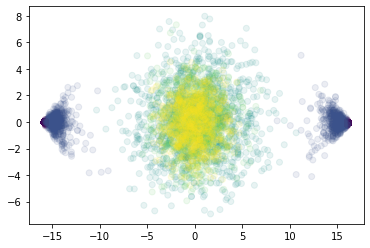

In [21]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(filterned_confs["T"]), alpha=0.1)

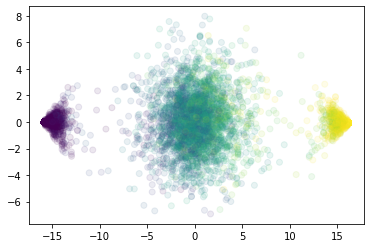

In [22]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(filterned_confs["M"]), alpha=0.1)

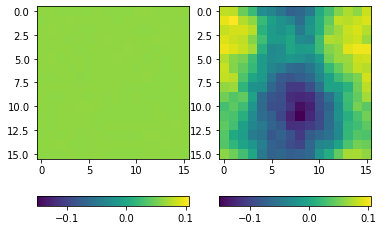

In [23]:
vmax = 0.0
vmin = 0.0
for i in range(N_DENSE):
    if max(img_pca.components_[i]) > vmax:
        vmax = max(img_pca.components_[i])
    
    if min(img_pca.components_[i]) < vmin:
        vmin = min(img_pca.components_[i])
        

fig_pca, (axes_pca, ax_color) = plt.subplots(2,N_DENSE, gridspec_kw={"height_ratios":[1, 0.05]})
im_list = []
for i, ax in enumerate(axes_pca.flat):
    im = ax.imshow(img_pca.components_[i].reshape(L,L), vmin=vmin, vmax=vmax)
    im_list.append(im)

for i, ax in enumerate(ax_color.flat):
    fig_pca.colorbar(im_list[i], cax=ax, orientation="horizontal")
plt.savefig("{}/s3-bucket/ising/pca_weights_as_image_l{}".format(prefix_s3, L))

In [24]:
df_components = pd.DataFrame(data={"c0": components[:,0], "c1": components[:,1], "T": pd.to_numeric(filterned_confs["T"])})

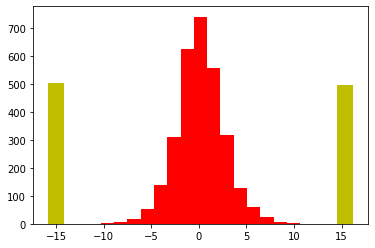

In [25]:
component_number = 0
plt.hist(df_components[df_components["T"] > 2]["c{}".format(component_number)], bins=15, color="r")
plt.hist(df_components[df_components["T"] < 2]["c{}".format(component_number)], bins=20, color="y")
#plt.show()
plt.savefig("{}/s3-bucket/reproduction/fig_2/pca_latent_param_hist_l{}.png".format(prefix_s3, L))

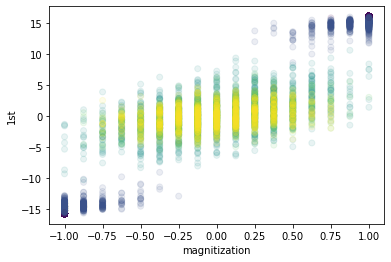

In [26]:
plt.scatter(pd.to_numeric(filterned_confs["M"]), components[:,0], c=pd.to_numeric(filterned_confs["T"]), alpha=0.1)
plt.xlabel("magnitization")
plt.ylabel("1st")
plt.savefig("{}/s3-bucket/reproduction/fig_2/pca_scatter_latent_vs_mag_color_by_t_l{}.png".format(prefix_s3, L))

# PCA Recreate from latent space

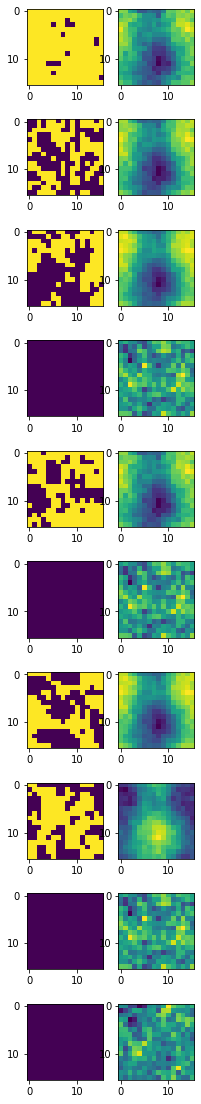

In [27]:

recreate_sample_size = 10

plt.figure(figsize=(3, recreate_sample_size*2))

sampled_look = test.sample(recreate_sample_size)

for i in range(recreate_sample_size):
    
    plt1 = plt.subplot2grid((recreate_sample_size,2), (i,0), colspan=1)
    plt2 = plt.subplot2grid((recreate_sample_size,2), (i,1), colspan=1)
    
    plt1.imshow(
        sampled_look.iloc[i].to_numpy().reshape(L,L)
    )
    plt2.imshow(
        img_pca.inverse_transform(img_pca.transform(sampled_look))[i].reshape(L,L)
    )


# Simple Autoencoder

In [28]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L*L,)),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(L*L),
    ]
)


2022-08-09 19:58:39.246807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 19:58:39.249820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 19:58:39.250072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 19:58:39.250497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [29]:
simp_ae.output_shape

(None, 256)

In [30]:
simp_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_space (Dense)        (None, 2)                 512       
                                                                 
 dense (Dense)               (None, 256)               768       
                                                                 
Total params: 1,280
Trainable params: 1,280
Non-trainable params: 0
_________________________________________________________________


In [31]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir='tb_log_dir_notebook',
    histogram_freq=2,  
    write_graph=True,
    write_images=True
)

In [32]:
simp_ae.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [33]:
simp_ae.fit(
    batch_size=16,
    x=filterned_confs.drop(["T","M"], axis=1),
    y=filterned_confs.drop(["T","M"], axis=1),
    epochs=50,
    callbacks=[tb_callback]
)

Epoch 1/50
313/313 [==============================] - 1s 1ms/step - loss: 0.6947 - mae: 0.6964
Epoch 2/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6185 - mae: 0.6225
Epoch 3/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6152 - mae: 0.6206
Epoch 4/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6124 - mae: 0.6181
Epoch 5/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6102 - mae: 0.6160
Epoch 6/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6090 - mae: 0.6145
Epoch 7/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6084 - mae: 0.6139
Epoch 8/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6082 - mae: 0.6136
Epoch 9/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6081 - mae: 0.6134
Epoch 10/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6080 - mae: 0.6132
Epoch 11/50
313/313 [============================

In [34]:
mid_layer = simp_ae.get_layer('latent_space')

In [35]:
mid_layer.get_weights()[0].shape

(256, 2)

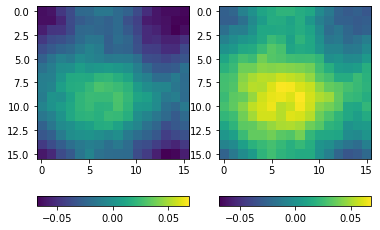

In [36]:
vmax = 0.0
vmin = 0.0
for i in range(N_DENSE):
    cur_w = mid_layer.get_weights()[0][:,-(i+1)]
    if max(cur_w) > vmax:
        vmax = max(cur_w)
    
    if min(cur_w) < vmin:
        vmin = min(cur_w)
        

fig, (axes, ax_color) = plt.subplots(2,N_DENSE, gridspec_kw={"height_ratios":[1, 0.05]})
im_list = []
axes_iter = None
if N_DENSE > 1:
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(mid_layer.get_weights()[0][:,-(i+1)].reshape(L,L), vmin=vmin, vmax=vmax)
        im_list.append(im)

    for i, ax in enumerate(ax_color.flat):
        fig.colorbar(im_list[i], cax=ax, orientation="horizontal")
else:
        im = axes.imshow(mid_layer.get_weights()[0][:,-(i+1)].reshape(L,L), vmin=vmin, vmax=vmax)
        im_list.append(im)
        fig.colorbar(im_list[0], cax=ax_color, orientation="horizontal")
        #plt.colorbar(x=axes, orientation="horizontal")

#plt.savefig("{}/s3-bucket/ising/ae_weights_as_image_l{}".format(prefix_s3, L))
plt.savefig("{}/s3-bucket/ising/linear_ae_latent_space_build_up_for_pca_compare/ae_weights_as_image_l{}_n_dense_{}".format(prefix_s3, L, N_DENSE))

In [37]:
max(mid_layer.get_weights()[0][:,-(i+1)])

0.06875514

In [38]:
full_latent_out = simp_ae.predict(filterned_confs.drop(["T","M"], axis=1))

157/157 [==============================] - 0s 614us/step


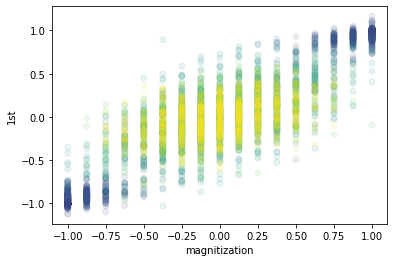

In [39]:
plt.scatter(pd.to_numeric(filterned_confs["M"]), full_latent_out[:,0], c=pd.to_numeric(filterned_confs["T"]), alpha=0.1)
plt.xlabel("magnitization")
plt.ylabel("1st")
plt.savefig("{}/s3-bucket/reproduction/fig_2/ae_scatter_latent_vs_mag_color_by_t_l{}.png".format(prefix_s3, L))

# Simple AE Latent Space

In [40]:
#mid_layer = simp_ae.get_layer('latent_space')
#mid_layer.output()

In [41]:
extractor = keras.Model(inputs=simp_ae.inputs,
                        outputs=[layer.output for layer in simp_ae.layers])

In [42]:
extractor

In [43]:
features = extractor(filterned_confs.drop(["T","M"], axis=1).to_numpy())

In [65]:
features[0].shape

TensorShape([5000, 2])

In [80]:
features[0][:,0]

<tf.Tensor: shape=(5000,), dtype=float32, numpy=
array([-4.685094  , -4.787857  , -4.787857  , ...,  0.04220799,
       -0.03706641, -0.3642087 ], dtype=float32)>

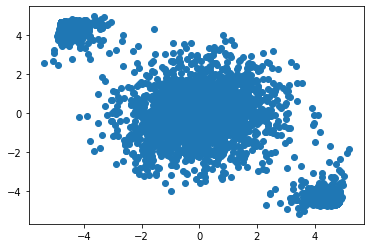

In [81]:
plt.scatter(features[0][:,0], features[0][:,1])

# Simple Autoencoder with Reshape

In [44]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L, L, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(units=L*L),
        keras.layers.Reshape(target_shape=(L, L, 1))
    ]
)

# Fig 2.c

In [45]:
filterned_confs["latent_1"] = full_latent_out[:,0]

In [46]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [47]:
filterned_confs.to_sql('filtered_confs', con=engine, if_exists='append')

In [48]:
avg_m_out = engine.execute(
"""
    select 
        t,
        avg(abs(m)),
        avg(abs(latent_1))
    from filtered_confs
    group by t
""").fetchall()

In [49]:
avg_m_out[1:]

[(1.0, 0.99975, 1.0001638402938844),
 (2.0, 0.9085, 0.9173303915858269),
 (3.0, 0.339625, 0.3077772655535955),
 (4.0, 0.258625, 0.20521252728893888),
 (5.0, 0.23795180722891565, 0.16779461879660487)]

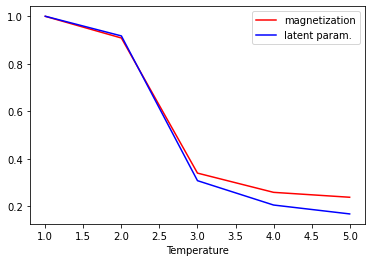

In [50]:
plt.plot(
    [i[0] for i in avg_m_out[1:]],
    [i[1] for i in avg_m_out[1:]],
    c='r',
    label="magnetization"
)
plt.plot(
    [i[0] for i in avg_m_out[1:]],
    [i[2] for i in avg_m_out[1:]],
    c='b',
    label="latent param."
)
plt.xlabel("Temperature")
plt.legend()
plt.savefig("{}/s3-bucket/reproduction/fig_2/pca_magnitization_and_latent_param_vs_temp_l{}.png".format(prefix_s3, L))

# Look into this

In [51]:
#engine.execute(
#"""
#    select 
#    m
#    from filterned_confs
#    where t is null
#""").fetchall()

# Simple AE Recreate from Latent Space

In [52]:
recreate_sample_size = 10

plt.figure(figsize=(3, recreate_sample_size*2))

sampled_look = filterned_confs.drop(["T","M"], axis=1).sample(recreate_sample_size)
sampled_latent_out = simp_ae.predict(sampled_look)

for i in range(recreate_sample_size):
    
    plt1 = plt.subplot2grid((recreate_sample_size,2), (i,0), colspan=1)
    plt2 = plt.subplot2grid((recreate_sample_size,2), (i,1), colspan=1)
    
    plt1.imshow(
        sampled_look.iloc[i].to_numpy().reshape(L,L)
    )
    plt2.imshow(
        sampled_latent_out[i].reshape(L,L)
    )


ValueError: in user code:

    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 16, 16, 1), found shape=(None, 257)


<Figure size 216x1440 with 0 Axes>